In [9]:
import os
import ollama
import json
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
current_dir = os.getcwd()
pdf_directory = os.path.join(current_dir, 'star wars')


# Dictionary to store index, content, embedding, and metadata
vector_db = {}

# Initialize index counter
index = 0

# Helper function to extract the movie name from the filename
def extract_movie_name(filename):
    # Remove file extension and replace underscores or hyphens with spaces
    movie_name = os.path.splitext(filename)[0].replace('_', ' ').replace('-', ' ')
    return movie_name

# Loop through each PDF in the directory
for filename in os.listdir(pdf_directory):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(pdf_directory, filename)
        print(f"Processing file: {pdf_path}")
        
        # Load the PDF
        loader = PyPDFLoader(pdf_path)
        pages = loader.load_and_split()
        
        # Extract the title (assuming it's on the first page and first line)
        title = pages[0].page_content.split("\n")[0]
        
        # Extract the movie name from the filename
        movie_name = extract_movie_name(filename)
        
        # Split the document into chunks
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=80)
        chunks = text_splitter.split_documents(pages)
        
        # Process each chunk
        for chunk in chunks:
            # Get chunk content (text)
            content = chunk.page_content
            
            # Generate embedding for the chunk using the Ollama embedding model
            response = ollama.embeddings(model="mxbai-embed-large", prompt=content)
            embedding = response["embedding"]
            
            # Create a dictionary entry for this chunk
            vector_db[f"index_{index}"] = {
                "content": content,
                "embedding": embedding,
                "metadata": {
                    "title": title,
                    "movie": movie_name  # Add the movie name to the metadata
                }
            }
            
            # Increment the index
            index += 1

# Save the dictionary as a JSON file
output_file = os.path.join(current_dir, 'star wars', 'vector_db.json')
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(vector_db, f, ensure_ascii=False, indent=4)

print(f"Vector database saved to {output_file}")


Processing file: /Users/tomas/Documents/Data_Viz/rag/star wars/A_New_Hope.pdf


ResponseError: model "mxbai-embed-large" not found, try pulling it first

/Users/tomas/Documents/Data_Viz/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


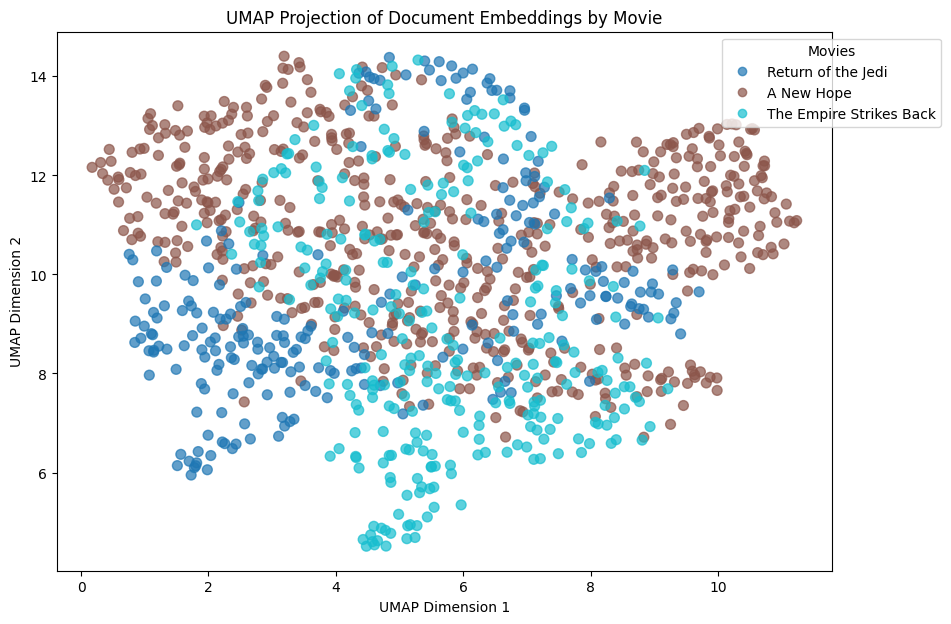

In [10]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)


embeddings = []
contents = []
titles = []
movies = [] 

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie']) 

embeddings = np.array(embeddings)

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

umap_reducer = umap.UMAP(n_neighbors=9, n_components=2, min_dist=0.5, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)

unique_movies = list(set(movies))  
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  
colors = [color_map[movie] for movie in movies]  

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)

legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                     labels=unique_movies, 
                     title="Movies", 
                     loc="upper right", bbox_to_anchor=(1.15, 1))

plt.title('UMAP Projection of Document Embeddings by Movie')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.show()


In [11]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from ollama import embeddings as ollama_embeddings  

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings before applying UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Apply UMAP for dimensionality reduction to 2D
umap_reducer = umap.UMAP(n_neighbors=9, n_components=2, min_dist=0.5, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)

# Step 5: Create a color map for movies
unique_movies = list(set(movies))  # Get a list of unique movie names
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  # Assign a unique color index to each movie
colors = [color_map[movie] for movie in movies]  # Map each chunk to a color based on its movie

# Step 6: Embed the query
query_text = "The Force will be with you. Always."  # Example query from Star Wars
query_embedding_response = ollama_embeddings(model="mxbai-embed-large", prompt=query_text)
query_embedding = query_embedding_response['embedding']

# Standardize the query embedding using the same scaler
query_embedding_scaled = scaler.transform([query_embedding])

# Project the query embedding into the UMAP space
query_embedding_2d = umap_reducer.transform(query_embedding_scaled)

# Step 7: Visualize the UMAP projections, colored by movie, and add the query as a star
plt.figure(figsize=(10, 7))

# Plot the movie embeddings
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)

# Plot the query as a distinct marker (e.g., star)
plt.scatter(query_embedding_2d[:, 0], query_embedding_2d[:, 1], color='red', marker='*', s=200, label='Query')

# Add a legend with movie names
legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                     labels=unique_movies, 
                     title="Movies", 
                     loc="upper right", bbox_to_anchor=(1.15, 1))

# Add the query legend
plt.legend(loc="upper left", title="Query Vector", labels=['Query Vector'])

plt.title('UMAP Projection of Document Embeddings by Movie with Query')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Show the plot
plt.show()


/Users/tomas/Documents/Data_Viz/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ResponseError: model "mxbai-embed-large" not found, try pulling it first

In [6]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from ollama import embeddings as ollama_embeddings  # Assuming this is how you embed a query

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings before applying UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Apply UMAP for dimensionality reduction to 2D
umap_reducer = umap.UMAP(n_neighbors=9, n_components=2, min_dist=0.5, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)

# Step 5: Create a color map for movies
unique_movies = list(set(movies))  # Get a list of unique movie names
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  # Assign a unique color index to each movie
colors = [color_map[movie] for movie in movies]  # Map each chunk to a color based on its movie

# Step 6: Embed the query
query_text = "The Force will be with you. Always."  # Example query from Star Wars
query_embedding_response = ollama_embeddings(model="mxbai-embed-large", prompt=query_text)
query_embedding = query_embedding_response['embedding']

# Standardize the query embedding using the same scaler
query_embedding_scaled = scaler.transform([query_embedding])

# Project the query embedding into the UMAP space
query_embedding_2d = umap_reducer.transform(query_embedding_scaled)

# Step 7: Nearest Neighbors Search
# Use NearestNeighbors to find the closest documents to the query
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embeddings_scaled)  # Adjust n_neighbors if needed
distances, indices = nbrs.kneighbors(query_embedding_scaled)

# Retrieve the nearest document titles and contents
retrieved_documents = [contents[i] for i in indices[0]]
retrieved_titles = [titles[i] for i in indices[0]]

# Print the retrieved documents and their titles
print("\nRetrieved Documents:")
for i, title in enumerate(retrieved_titles):
    print(f"Neighbor {i+1}: {title}")
    print(f"Document Content (Preview): {retrieved_documents[i][:200]}...\n")  # Print only the first 200 characters

# Step 8: Visualize the UMAP projections, colored by movie, and add the query as a star
plt.figure(figsize=(10, 7))

# Plot the movie embeddings
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)

# Plot the query as a distinct marker (e.g., star)
plt.scatter(query_embedding_2d[:, 0], query_embedding_2d[:, 1], color='red', marker='*', s=200, label='Query')

# Plot the nearest neighbors as triangles
neighbor_embeddings_2d = embeddings_2d[indices[0]]
plt.scatter(neighbor_embeddings_2d[:, 0], neighbor_embeddings_2d[:, 1], color='green', marker='^', s=150, label='Nearest Neighbors')

# Add a legend with movie names
legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                     labels=unique_movies, 
                     title="Movies", 
                     loc="upper right", bbox_to_anchor=(1.15, 1))

# Add the query and neighbors legend
plt.legend(loc="upper left", title="Query & Neighbors", labels=['Query Vector', 'Nearest Neighbors'])

plt.title('UMAP Projection of Document Embeddings by Movie with Query and Nearest Neighbors')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Show the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'rag/star wars/vector_db.json'

c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Retrieved Documents:
Neighbor 1: STAR WARS
Document Content (Preview): lies along a different path than 
                         mine. The Force will be with you... 
                         always!
               Ben adjusts the lightsaber on his belt and silently step...

Neighbor 2: THE EMPIRE STRIKES BACK
Document Content (Preview): ally it is.  Life creates it, makes 
		it grow.  Its energy surrounds us 
		and binds us.  Luminous beings 
		are we...
			(Yoda pinches 
			 Luke's shoulder)
		... not this crude matter.
			(a sweepi...

Neighbor 3: STAR WARS
Document Content (Preview): VADER
                         Don't underestimate the power of the 
                         Force....

Neighbor 4: STAR WARS
Document Content (Preview): alert!
                                     VADER
                         Obi-Wan is here. The Force is with 
                         him.
                                     TARKIN
               ...

Neighbor 5: THE EMPIRE STRIKES BACK
Document

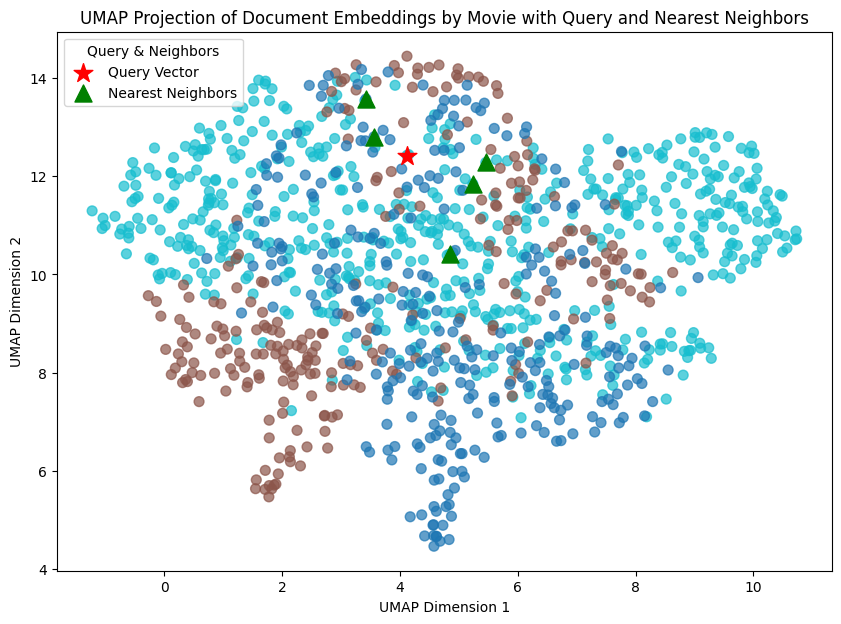

In [144]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from ollama import embeddings as ollama_embeddings  # Assuming this is how you embed a query

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings before applying UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Apply UMAP for dimensionality reduction to 2D
umap_reducer = umap.UMAP(n_neighbors=9, n_components=2, min_dist=0.5, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)

# Step 5: Create a color map for movies
unique_movies = list(set(movies))  # Get a list of unique movie names
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  # Assign a unique color index to each movie
colors = [color_map[movie] for movie in movies]  # Map each chunk to a color based on its movie

# Step 6: Embed the query
query_text = "The Force will be with you. Always."  # Example query from Star Wars
query_embedding_response = ollama_embeddings(model="mxbai-embed-large", prompt=query_text)
query_embedding = query_embedding_response['embedding']

# Standardize the query embedding using the same scaler
query_embedding_scaled = scaler.transform([query_embedding])

# Project the query embedding into the UMAP space
query_embedding_2d = umap_reducer.transform(query_embedding_scaled)

# Step 7: Nearest Neighbors Search
# Use NearestNeighbors to find the closest documents to the query
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embeddings_scaled)  # Adjust n_neighbors if needed
distances, indices = nbrs.kneighbors(query_embedding_scaled)

# Retrieve the nearest document titles and contents
retrieved_documents = [contents[i] for i in indices[0]]
retrieved_titles = [titles[i] for i in indices[0]]

# Print the retrieved documents and their titles
print("\nRetrieved Documents:")
for i, title in enumerate(retrieved_titles):
    print(f"Neighbor {i+1}: {title}")
    print(f"Document Content (Preview): {retrieved_documents[i][:200]}...\n")  # Print only the first 200 characters

# Step 8: Visualize the UMAP projections, colored by movie, and add the query as a star
plt.figure(figsize=(10, 7))

# Plot the movie embeddings
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)

# Plot the query as a distinct marker (e.g., star)
query_plot = plt.scatter(query_embedding_2d[:, 0], query_embedding_2d[:, 1], color='red', marker='*', s=200, label='Query Vector')

# Plot the nearest neighbors as triangles
neighbor_embeddings_2d = embeddings_2d[indices[0]]
neighbor_plot = plt.scatter(neighbor_embeddings_2d[:, 0], neighbor_embeddings_2d[:, 1], color='green', marker='^', s=150, label='Nearest Neighbors')

# Add a legend with movie names
legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                     labels=unique_movies, 
                     title="Movies", 
                     loc="upper right", bbox_to_anchor=(1.15, 1))

# Add the query and neighbors legend separately to avoid confusion
plt.legend([query_plot, neighbor_plot], ['Query Vector', 'Nearest Neighbors'], loc="upper left", title="Query & Neighbors")

plt.title('UMAP Projection of Document Embeddings by Movie with Query and Nearest Neighbors')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Show the plot
plt.show()


In [148]:
import json
import numpy as np
import umap
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from ollama import embeddings as ollama_embeddings  # Assuming this is how you embed a query

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings before applying UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Apply UMAP for dimensionality reduction to 3D
umap_reducer = umap.UMAP(n_neighbors=9, n_components=3, min_dist=0.5, random_state=42)
embeddings_3d = umap_reducer.fit_transform(embeddings_scaled)

# Step 5: Create a color map for movies
unique_movies = list(set(movies))  # Get a list of unique movie names
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  # Assign a unique color index to each movie
colors = [color_map[movie] for movie in movies]  # Map each chunk to a color based on its movie

# Step 6: Embed the query
query_text = "The Force will be with you. Always."  # Example query from Star Wars
query_embedding_response = ollama_embeddings(model="mxbai-embed-large", prompt=query_text)
query_embedding = query_embedding_response['embedding']

# Standardize the query embedding using the same scaler
query_embedding_scaled = scaler.transform([query_embedding])

# Project the query embedding into the UMAP 3D space
query_embedding_3d = umap_reducer.transform(query_embedding_scaled)

# Step 7: Nearest Neighbors Search
# Use NearestNeighbors to find the closest documents to the query
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embeddings_scaled)  # Adjust n_neighbors if needed
distances, indices = nbrs.kneighbors(query_embedding_scaled)

# Retrieve the nearest document titles and contents
retrieved_documents = [contents[i] for i in indices[0]]
retrieved_titles = [titles[i] for i in indices[0]]

# Print the retrieved documents and their titles
print("\nRetrieved Documents:")
for i, title in enumerate(retrieved_titles):
    print(f"Neighbor {i+1}: {title}")
    print(f"Document Content (Preview): {retrieved_documents[i][:200]}...\n")  # Print only the first 200 characters

# Step 8: Plotly 3D scatter plot

# 3D scatter plot for movie embeddings
trace_movies = go.Scatter3d(
    x=embeddings_3d[:, 0], 
    y=embeddings_3d[:, 1], 
    z=embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=colors,  # Color by movie
        colorscale='Viridis',
        opacity=0.8
    ),
    text=movies,  # Hover text will show the movie name
    name="Movie Embeddings"
)

# 3D scatter plot for query vector
trace_query = go.Scatter3d(
    x=[query_embedding_3d[0, 0]], 
    y=[query_embedding_3d[0, 1]], 
    z=[query_embedding_3d[0, 2]],
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        symbol='diamond',  # Use a valid Plotly symbol like 'diamond'
        opacity=1.0
    ),
    text=["Query Vector"],
    name="Query Vector"
)

# 3D scatter plot for nearest neighbors
neighbor_embeddings_3d = embeddings_3d[indices[0]]  # Get the 3D positions of the neighbors
trace_neighbors = go.Scatter3d(
    x=neighbor_embeddings_3d[:, 0], 
    y=neighbor_embeddings_3d[:, 1], 
    z=neighbor_embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color='green',
        symbol='cross',  # Use a valid Plotly symbol like 'cross'
        opacity=1.0
    ),
    text=["Neighbor " + str(i+1) for i in range(len(indices[0]))],  # Label the neighbors
    name="Nearest Neighbors"
)

# Combine all traces into one figure
fig = go.Figure(data=[trace_movies, trace_query, trace_neighbors])

# Update layout for better visualization
fig.update_layout(
    title="3D UMAP Projection of Document Embeddings with Query and Nearest Neighbors",
    scene=dict(
        xaxis_title='UMAP Dimension 1',
        yaxis_title='UMAP Dimension 2',
        zaxis_title='UMAP Dimension 3'
    ),
    legend=dict(
        x=0.85,
        y=1,
        bgcolor="rgba(255, 255, 255, 0.5)"
    )
)

# Show the plot
fig.show(renderer="browser")


c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Retrieved Documents:
Neighbor 1: STAR WARS
Document Content (Preview): lies along a different path than 
                         mine. The Force will be with you... 
                         always!
               Ben adjusts the lightsaber on his belt and silently step...

Neighbor 2: THE EMPIRE STRIKES BACK
Document Content (Preview): ally it is.  Life creates it, makes 
		it grow.  Its energy surrounds us 
		and binds us.  Luminous beings 
		are we...
			(Yoda pinches 
			 Luke's shoulder)
		... not this crude matter.
			(a sweepi...

Neighbor 3: STAR WARS
Document Content (Preview): VADER
                         Don't underestimate the power of the 
                         Force....

Neighbor 4: STAR WARS
Document Content (Preview): alert!
                                     VADER
                         Obi-Wan is here. The Force is with 
                         him.
                                     TARKIN
               ...

Neighbor 5: THE EMPIRE STRIKES BACK
Document

In [149]:
import json
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from ollama import embeddings as ollama_embeddings  # Assuming this is how you embed a query

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings (this applies to both retrieval methods)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Apply UMAP for dimensionality reduction to 3D
umap_reducer = umap.UMAP(n_neighbors=9, n_components=3, min_dist=0.5, random_state=42)
embeddings_umap = umap_reducer.fit_transform(embeddings_scaled)

# Step 5: Embed the query
query_text = "The Force will be with you. Always."  # Example query from Star Wars
query_embedding_response = ollama_embeddings(model="mxbai-embed-large", prompt=query_text)
query_embedding = query_embedding_response['embedding']

# Standardize the query embedding using the same scaler
query_embedding_scaled = scaler.transform([query_embedding])

# Step 6: Nearest Neighbors Search (Without UMAP)
nbrs_original = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embeddings_scaled)
distances_original, indices_original = nbrs_original.kneighbors(query_embedding_scaled)

# Step 7: Nearest Neighbors Search (With UMAP)
nbrs_umap = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embeddings_umap)
distances_umap, indices_umap = nbrs_umap.kneighbors(umap_reducer.transform(query_embedding_scaled))

# Step 8: Retrieve documents for both approaches
retrieved_original = [contents[i] for i in indices_original[0]]
retrieved_umap = [contents[i] for i in indices_umap[0]]

# Print the retrieved documents
print("\nRetrieved Documents (Without UMAP):")
for i, title in enumerate([titles[i] for i in indices_original[0]]):
    print(f"Original Neighbor {i+1}: {title}")
    print(f"Document Content (Preview): {retrieved_original[i][:200]}...\n")  # Print only the first 200 characters

print("\nRetrieved Documents (With UMAP):")
for i, title in enumerate([titles[i] for i in indices_umap[0]]):
    print(f"UMAP Neighbor {i+1}: {title}")
    print(f"Document Content (Preview): {retrieved_umap[i][:200]}...\n")  # Print only the first 200 characters


c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Retrieved Documents (Without UMAP):
Original Neighbor 1: STAR WARS
Document Content (Preview): lies along a different path than 
                         mine. The Force will be with you... 
                         always!
               Ben adjusts the lightsaber on his belt and silently step...

Original Neighbor 2: THE EMPIRE STRIKES BACK
Document Content (Preview): ally it is.  Life creates it, makes 
		it grow.  Its energy surrounds us 
		and binds us.  Luminous beings 
		are we...
			(Yoda pinches 
			 Luke's shoulder)
		... not this crude matter.
			(a sweepi...

Original Neighbor 3: STAR WARS
Document Content (Preview): VADER
                         Don't underestimate the power of the 
                         Force....

Original Neighbor 4: STAR WARS
Document Content (Preview): alert!
                                     VADER
                         Obi-Wan is here. The Force is with 
                         him.
                                     TARKIN
             

In [152]:
retrieved_original

['lies along a different path than \n                         mine. The Force will be with you... \n                         always!\n               Ben adjusts the lightsaber on his belt and silently steps \n               out of the command office, then disappears down a long grey \n               hallway. Chewbacca barks a comment and Han shakes his head \n               in agreement.',
 "ally it is.  Life creates it, makes \n\t\tit grow.  Its energy surrounds us \n\t\tand binds us.  Luminous beings \n\t\tare we...\n\t\t\t(Yoda pinches \n\t\t\t Luke's shoulder)\n\t\t... not this crude matter.\n\t\t\t(a sweeping gesture)\n\t\tYou must feel the Force around you.\n\t\t\t(gesturing)\n\t\tHere, between you... me... the \n\t\ttree... the rock... everywhere!  \n\t\tYes, even between this land and \n\t\tthat ship!\n\t\t\t\tLUKE\n\t\t\t(discouraged)\n\t\tYou want the impossible.\nQuietly Yoda turns toward the X-wing fighter.  With his eyes closed and \nhis head bowed, he raises his arm and p

In [162]:
from langchain_ollama.llms import OllamaLLM

# Initialize the model
llm = OllamaLLM(model='llama3.2:1b')

# Define the retrieved documents (context)
retrieved_original = [
    'lies along a different path than \n                         mine. The Force will be with you... \n                         always!\n               Ben adjusts the lightsaber on his belt and silently steps \n               out of the command office, then disappears down a long grey \n               hallway. Chewbacca barks a comment and Han shakes his head \n               in agreement.',
    "ally it is.  Life creates it, makes \n\t\tit grow.  Its energy surrounds us \n\t\tand binds us.  Luminous beings \n\t\tare we...\n\t\t\t(Yoda pinches \n\t\t\t Luke's shoulder)\n\t\t... not this crude matter.\n\t\t\t(a sweeping gesture)\n\t\tYou must feel the Force around you.\n\t\t\t(gesturing)\n\t\tHere, between you... me... the \n\t\ttree... the rock... everywhere!  \n\t\tYes, even between this land and \n\t\tthat ship!\n\t\t\t\tLUKE\n\t\t\t(discouraged)\n\t\tYou want the impossible.\nQuietly Yoda turns toward the X-wing fighter.  With his eyes closed and \nhis head bowed, he raises his arm and points at the ship.\nSoon, the fighter rises above the water and moves forward as Artoo \nbeeps in terror and scoots away.\nThe entire X-wing moves majestically, surely, toward the shore.  Yoda",
    "VADER\n                         Don't underestimate the power of the \n                         Force.",
    "alert!\n                                     VADER\n                         Obi-Wan is here. The Force is with \n                         him.\n                                     TARKIN\n                         If you're right, he must not be \n                         allowed to escape.",
    "But Han and Leia will die if I \n\t\tdon't.\n\t\t\t\tBEN'S VOICE\n\t\tYou don't know that.\nLuke looks toward the voice in amazement.  Ben has materialized as a \nreal, slightly shimmering image near Yoda.  The power of his presence \nstops Luke.\n\t\t\t\tBEN\n\t\tEven Yoda cannot see their fate.\n\t\t\t\tLUKE\n\t\tBut I can help them!  I feel \n\t\tthe Force!\n\t\t\t\tBEN\n\t\tBut you cannot control it.  This \n\t\tis a dangerous time for you, \n\t\twhen you will be tempted by the \n\t\tdark side of the Force.\n\t\t\t\tYODA\n\t\tYes, yes.  To Obi-Wan you listen.\n\t\tThe cave.  Remember your failure \n\t\tat the cave!"
]

# Query to ask the model
query = "What is the role of the Force in guiding Luke?"

# Format the context into a single string
context = "\n\n".join(retrieved_original)

# Formulate the input for the model (you can adjust how you pass the context if needed)
input_text = f"Context: {context}\n\nQuestion: {query}"

print(input_text)

# Invoke the model with the context and the question
response = llm.invoke(input_text)

# Print the model's response
print("Response from the model:")
print(response)


Context: lies along a different path than 
                         mine. The Force will be with you... 
                         always!
               Ben adjusts the lightsaber on his belt and silently steps 
               out of the command office, then disappears down a long grey 
               hallway. Chewbacca barks a comment and Han shakes his head 
               in agreement.

ally it is.  Life creates it, makes 
		it grow.  Its energy surrounds us 
		and binds us.  Luminous beings 
		are we...
			(Yoda pinches 
			 Luke's shoulder)
		... not this crude matter.
			(a sweeping gesture)
		You must feel the Force around you.
			(gesturing)
		Here, between you... me... the 
		tree... the rock... everywhere!  
		Yes, even between this land and 
		that ship!
				LUKE
			(discouraged)
		You want the impossible.
Quietly Yoda turns toward the X-wing fighter.  With his eyes closed and 
his head bowed, he raises his arm and points at the ship.
Soon, the fighter rises above the water 

In [163]:
from langchain_ollama.llms import OllamaLLM

# Initialize the model
llm = OllamaLLM(model='llama3.2:1b')

# Define the retrieved documents (context)
retrieved_original = [
    'lies along a different path than \n                         mine. The Force will be with you... \n                         always!\n               Ben adjusts the lightsaber on his belt and silently steps \n               out of the command office, then disappears down a long grey \n               hallway. Chewbacca barks a comment and Han shakes his head \n               in agreement.',
    "ally it is.  Life creates it, makes \n\t\tit grow.  Its energy surrounds us \n\t\tand binds us.  Luminous beings \n\t\tare we...\n\t\t\t(Yoda pinches \n\t\t\t Luke's shoulder)\n\t\t... not this crude matter.\n\t\t\t(a sweeping gesture)\n\t\tYou must feel the Force around you.\n\t\t\t(gesturing)\n\t\tHere, between you... me... the \n\t\ttree... the rock... everywhere!  \n\t\tYes, even between this land and \n\t\tthat ship!\n\t\t\t\tLUKE\n\t\t\t(discouraged)\n\t\tYou want the impossible.\nQuietly Yoda turns toward the X-wing fighter.  With his eyes closed and \nhis head bowed, he raises his arm and points at the ship.\nSoon, the fighter rises above the water and moves forward as Artoo \nbeeps in terror and scoots away.\nThe entire X-wing moves majestically, surely, toward the shore.  Yoda",
    "VADER\n                         Don't underestimate the power of the \n                         Force.",
    "alert!\n                                     VADER\n                         Obi-Wan is here. The Force is with \n                         him.\n                                     TARKIN\n                         If you're right, he must not be \n                         allowed to escape.",
    "But Han and Leia will die if I \n\t\tdon't.\n\t\t\t\tBEN'S VOICE\n\t\tYou don't know that.\nLuke looks toward the voice in amazement.  Ben has materialized as a \nreal, slightly shimmering image near Yoda.  The power of his presence \nstops Luke.\n\t\t\t\tBEN\n\t\tEven Yoda cannot see their fate.\n\t\t\t\tLUKE\n\t\tBut I can help them!  I feel \n\t\tthe Force!\n\t\t\t\tBEN\n\t\tBut you cannot control it.  This \n\t\tis a dangerous time for you, \n\t\twhen you will be tempted by the \n\t\tdark side of the Force.\n\t\t\t\tYODA\n\t\tYes, yes.  To Obi-Wan you listen.\n\t\tThe cave.  Remember your failure \n\t\tat the cave!"
]

# Query to ask the model
query = "How did the Force guide Luke Skywalker through his trials and interactions with Obi-Wan and Yoda?"

# Constructing the system prompt
system_prompt = (
    "You are a Jedi historian and scholar of the Force, entrusted with documenting and interpreting the teachings, trials, and wisdom of the Jedi Order. "
    "Your duty is to analyze and explain the mystical ways of the Force in guiding the Jedi through their journeys, while being precise, concise, and insightful.\n"
    "You are now tasked with explaining how the Force shaped the path of Jedi Knight Luke Skywalker during his trials, interactions with Obi-Wan Kenobi, and guidance from Yoda.\n"
    "Use the context provided below and answer in no more than four sentences, distilling the essence of the Force's influence over Luke's journey.\n\n"
)

# Combine the system prompt, context, and question
context = "\n\n".join(retrieved_original)
input_text = f"{system_prompt}Context:\n{context}\n\nQuestion: {query}"


print(input_text,'\n')

# Invoke the model with the system prompt, context, and the question
response = llm.invoke(input_text)

# Print the model's response
print("Response from the model:")
print(response)


You are a Jedi historian and scholar of the Force, entrusted with documenting and interpreting the teachings, trials, and wisdom of the Jedi Order. Your duty is to analyze and explain the mystical ways of the Force in guiding the Jedi through their journeys, while being precise, concise, and insightful.
You are now tasked with explaining how the Force shaped the path of Jedi Knight Luke Skywalker during his trials, interactions with Obi-Wan Kenobi, and guidance from Yoda.
Use the context provided below and answer in no more than four sentences, distilling the essence of the Force's influence over Luke's journey.

Context:
lies along a different path than 
                         mine. The Force will be with you... 
                         always!
               Ben adjusts the lightsaber on his belt and silently steps 
               out of the command office, then disappears down a long grey 
               hallway. Chewbacca barks a comment and Han shakes his head 
               i

In [164]:
print("Response from the model:")
print(response)

Response from the model:
As a Jedi historian and scholar of the Force, I can distill the essence of its influence over Luke's journey as follows:

The Force guided Luke through his trials by providing him with visions and insights that allowed him to understand his connection to the living Force and ultimately discover his own potential. The Force also assisted him in deciphering Obi-Wan Kenobi's warnings, which revealed a deeper understanding of their shared fate. Moreover, the Force enabled Yoda to impart crucial guidance on Luke's path, particularly when it came to navigating the complexities of the dark side and confronting his own doubts and fears. Ultimately, the Force nudged Luke towards recognizing his connection to Obi-Wan and encouraged him to rely on his inner light, allowing him to overcome the challenges he faced during his time with Obi-Wan Kenobi.


In [160]:
import json
import numpy as np
from sklearn.neighbors import NearestNeighbors
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.messages import AIMessage
from langchain_community.chat_message_histories import ChatMessageHistory

# Initialize LLM
llm = OllamaLLM(model='llama3.2:1b')

# Load custom vector DB from JSON
current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')
with open(input_file, 'r') as f:
    vector_db = json.load(f)

# Extract embeddings and content
embeddings = []
contents = []
for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])

# Convert to numpy array for further processing
embeddings = np.array(embeddings)

# Use Nearest Neighbors to find similar documents based on query embeddings
nn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
nn_model.fit(embeddings)

# Custom function to retrieve documents based on query
def custom_retriever(query_embedding):
    distances, indices = nn_model.kneighbors([query_embedding])
    retrieved_docs = [contents[idx] for idx in indices[0]]
    return retrieved_docs

# Step 1: Contextualize Questions (History-Aware Retriever)
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# Custom function to handle history-aware retrieval
def history_aware_custom_retriever(query, chat_history):
    # Embed the query using the LLM embedding model
    query_embedding = llm.embed_query(query)
    
    # Retrieve documents using the custom retriever
    retrieved_docs = custom_retriever(query_embedding)
    
    return retrieved_docs

# Step 2: Answer the Questions (LLM Generation)
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# Chain that combines the retrieved documents and generates answers
def generate_answer(query, chat_history):
    # Contextualize the query using history
    contextualized_query = contextualize_q_prompt.format(input=query, chat_history=chat_history)
    
    # Retrieve relevant documents
    retrieved_docs = history_aware_custom_retriever(contextualized_query, chat_history)
    
    # Combine retrieved documents into a context
    context = "\n\n".join(retrieved_docs)
    
    # Generate response using LLM
    response = llm.generate(qa_prompt.format(input=query, context=context))
    
    return response, retrieved_docs

# Step 3: Stateful Chat History Management
store = {}

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

# Final chain with stateful history and document retrieval
def conversational_rag_chain(query, session_id):
    # Retrieve chat history
    chat_history = get_session_history(session_id).messages
    
    # Generate the answer and get retrieved documents
    answer, retrieved_docs = generate_answer(query, chat_history)
    
    # Update chat history
    store[session_id].add_user_message(query)
    store[session_id].add_ai_message(answer)
    
    return answer, retrieved_docs

### Example Usage ###

session_id = "example_session_1"

# First Question
question_1 = "What is The Force"
answer_1, retrieved_docs_1 = conversational_rag_chain(question_1, session_id)
print("Answer 1:", answer_1)
print("Retrieved Docs 1:", retrieved_docs_1)

# Second Question, with chat history retained
question_2 = "Who uses it?"
answer_2, retrieved_docs_2 = conversational_rag_chain(question_2, session_id)
print("Answer 2:", answer_2)
print("Retrieved Docs 2:", retrieved_docs_2)

# Inspect the chat history
for message in store[session_id].messages:
    prefix = "AI" if isinstance(message, AIMessage) else "User"
    print(f"{prefix}: {message.content}\n")


AttributeError: 'OllamaLLM' object has no attribute 'embed_query'

In [151]:
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM

llm = OllamaLLM(model='llama3.2:1b')


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [153]:
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

query_text = "The Force will be with you. Always."  # Example query from Star Wars


In [159]:
import bs4
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM
from langchain_community.chat_message_histories import ChatMessageHistory

# 0. LLM


llm = OllamaLLM(model='mistral:instruct')

# 1. Load the existing ChromaDB from disk
embedding_model = OllamaEmbeddings(model="mxbai-embed-large:latest")

vector_db = Chroma(
    persist_directory=r'C:\Users\ezequ\anyoneai\final_project\vector_db\chroma_db',
    embedding_function=embedding_model  # Ensure you use the same embedding function
)

# Convert the vector store into a retriever
retriever = vector_db.as_retriever()

# 2. Create the prompt and question-answering chain
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

# Assuming you have an instance of a language model, e.g., `llm`
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

# Now you can use `rag_chain` to answer questions based on your vector database

from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate

# Contextualize the user question based on chat history
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# Create the history-aware retriever
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

# Update the main RAG chain to use the history-aware retriever
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

# Example usage:
response = rag_chain.invoke({
    "input": "What are common ways of doing it?",
    "chat_history": [
        {"role": "human", "content": "What is Task Decomposition?"},
        {"role": "ai", "content": "Task decomposition involves breaking down complex tasks into smaller and simpler steps..."}
    ]
})

print(response["answer"])





ModuleNotFoundError: No module named 'bs4'

In [ ]:
import os
from nltk.tokenize import sent_tokenize
from langchain.document_loaders import PyPDFLoader
import nltk
nltk.download('punkt')

current_dir = os.getcwd()
pdf_directory = os.path.join(current_dir, 'star wars')

# Function to extract title from the first page
def extract_title(pages):
    first_page = pages[0].page_content
    title = first_page.split("\n")[0].strip()
    return title

# Function to chunk text based on sentences using NLTK
def nltk_sentence_chunker(text, chunk_size=1000, chunk_overlap=100):
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        sentence_length = len(sentence)
        
        # If adding this sentence exceeds the chunk size, start a new chunk
        if current_length + sentence_length > chunk_size:
            chunks.append(" ".join(current_chunk))
            
            # Handle overlap: Take the last few sentences for the next chunk
            overlap_sentences = current_chunk[-chunk_overlap:]
            current_chunk = overlap_sentences
            current_length = sum(len(s) for s in overlap_sentences)

        # Add sentence to the current chunk
        current_chunk.append(sentence)
        current_length += sentence_length

    # Add the last chunk if there is remaining text
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    
    return chunks

# Function to process a single PDF file
def process_pdf(pdf_path, chunk_size=1000, chunk_overlap=100):
    # Load the PDF
    loader = PyPDFLoader(pdf_path)
    pages = loader.load_and_split()
    
    # Extract the title from the first page
    title = extract_title(pages)
    
    # Concatenate all page content into a single text
    full_text = "\n\n".join([page.page_content for page in pages])
    
    # Split the full text into chunks using NLTK sentence chunker
    chunks = nltk_sentence_chunker(full_text, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    
    # Add metadata (title) to each chunk
    documents = []
    for chunk in chunks:
        document = {
            "page_content": chunk,
            "metadata": {"title": title}
        }
        documents.append(document)
    
    return documents

# Process all PDFs in the specified directory
def process_all_pdfs_in_directory(directory_path, chunk_size=1000, chunk_overlap=100):
    documents = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(directory_path, filename)
            print(f"Processing: {pdf_path}")
            
            # Process each PDF and append chunks to the documents list
            doc_chunks = process_pdf(pdf_path, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
            documents.extend(doc_chunks)
    
    return documents

# Example usage
if __name__ == "__main__":
    # Process all PDFs in the directory and retrieve the documents with metadata
    documents = process_all_pdfs_in_directory(pdf_directory, chunk_size=1000, chunk_overlap=100)
    
    # Output some information about the chunks created
    print(f"Total Chunks Created: {len(documents)}")
    print("Sample Chunk Metadata:")
    for i, doc in enumerate(documents[:3]):
        print(f"Chunk {i+1}: Title - {doc['metadata']['title']}")
        print(f"Content Preview: {doc['page_content'][:100]}...\n")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ezequ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processing: C:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\rag\star wars\A_New_Hope.pdf


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\ezequ/nltk_data'
    - 'c:\\Users\\ezequ\\OneDrive\\Documentos\\Facultad\\data viz\\env\\nltk_data'
    - 'c:\\Users\\ezequ\\OneDrive\\Documentos\\Facultad\\data viz\\env\\share\\nltk_data'
    - 'c:\\Users\\ezequ\\OneDrive\\Documentos\\Facultad\\data viz\\env\\lib\\nltk_data'
    - 'C:\\Users\\ezequ\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
import bs4
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM

# 0. LLM


llm = OllamaLLM(model='mistral:instruct')

# 1. Load the existing ChromaDB from disk
embedding_model = OllamaEmbeddings(model="mxbai-embed-large:latest")

vector_db = Chroma(
    persist_directory=r'C:\Users\ezequ\anyoneai\final_project\vector_db\chroma_db',
    embedding_function=embedding_model  # Ensure you use the same embedding function
)

# Convert the vector store into a retriever
retriever = vector_db.as_retriever()

# 2. Create the prompt and question-answering chain
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

# Assuming you have an instance of a language model, e.g., `llm`
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

# Now you can use `rag_chain` to answer questions based on your vector database

from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate

# Contextualize the user question based on chat history
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# Create the history-aware retriever
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

# Update the main RAG chain to use the history-aware retriever
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

# Example usage:
response = rag_chain.invoke({
    "input": "What are common ways of doing it?",
    "chat_history": [
        {"role": "human", "content": "What is Task Decomposition?"},
        {"role": "ai", "content": "Task decomposition involves breaking down complex tasks into smaller and simpler steps..."}
    ]
})

print(response["answer"])





In [ ]:
llm = OllamaLLM(model='llama3.2:1b')





c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: Us

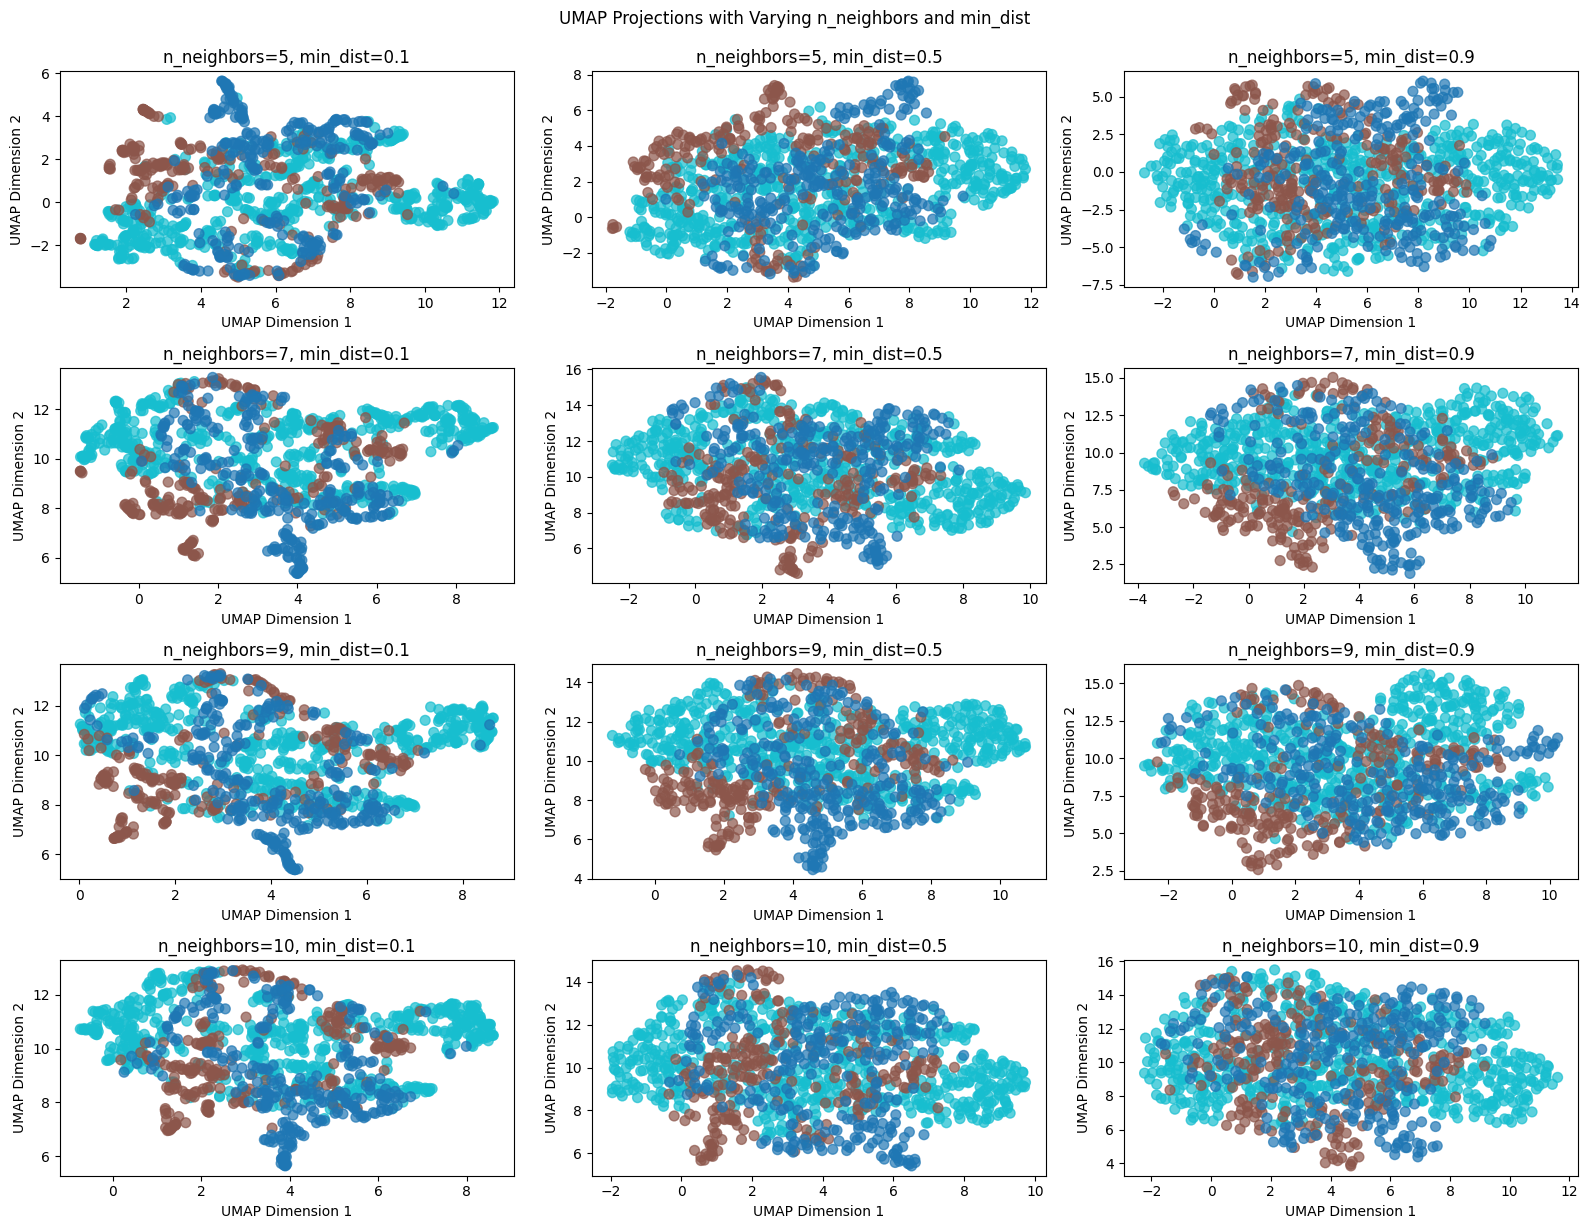

In [138]:
import json
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

current_dir = os.getcwd()
input_file = os.path.join(current_dir, 'star wars', 'vector_db.json')

with open(input_file, 'r', encoding='utf-8') as f:
    vector_db = json.load(f)

# Step 2: Extract embeddings, content, titles, and movie names from the JSON
embeddings = []
contents = []
titles = []
movies = []  # We'll store the movie names here

for key, value in vector_db.items():
    embeddings.append(value['embedding'])
    contents.append(value['content'])
    titles.append(value['metadata']['title'])
    movies.append(value['metadata']['movie'])  # Extract the movie name for coloring

# Convert embeddings list into a NumPy array for further processing
embeddings = np.array(embeddings)

# Step 3: Standardize the embeddings before applying UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 4: Set up the grid of hyperparameters to search over
n_neighbors_values = [5, 7, 9, 10]  # Range of n_neighbors to try
min_dist_values = [0.1, 0.5, 0.9]      # Range of min_dist values to try

# Create a color map for movies
unique_movies = list(set(movies))  # Get a list of unique movie names
color_map = {movie: idx for idx, movie in enumerate(unique_movies)}  # Assign a unique color index to each movie
colors = [color_map[movie] for movie in movies]  # Map each chunk to a color based on its movie

# Step 5: Perform the grid search and plot each result
plt.figure(figsize=(16, 12))  # Adjust figure size to display multiple plots

plot_num = 1
for n_neighbors in n_neighbors_values:
    for min_dist in min_dist_values:
        # Apply UMAP with the current set of hyperparameters
        umap_reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, random_state=42)
        embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)
        
        # Plot the UMAP projections
        plt.subplot(len(n_neighbors_values), len(min_dist_values), plot_num)
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap='tab10', s=50, alpha=0.7)
        
        plt.title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        
        plot_num += 1

# Adjust layout and show the plots
plt.tight_layout()
plt.suptitle('UMAP Projections with Varying n_neighbors and min_dist', y=1.02)
plt.show()


In [28]:
import os
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

current_dir = os.getcwd()
pdf_directory = os.path.join(current_dir, 'star wars')

# List to store documents with metadata
documents = []

# Loop through each PDF in the directory
for filename in os.listdir(pdf_directory):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(pdf_directory, filename)
        
        # Load the PDF
        loader = PyPDFLoader(pdf_path)
        pages = loader.load_and_split()
        
        # Extract the title (assuming it's on the first page and first line)
        title = pages[0].page_content.split("\n")[0]       
        text_splitter = RecursiveCharacterTextSplitter(chunk_size= 800, chunk_overlap=80)
        chunks = text_splitter.split_documents(pages)
        
        # Add title as metadata to each chunk
        for chunk in chunks:
            chunk.metadata["title"] = title
            documents.append(chunk)



In [37]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
embedding_model = OllamaEmbeddings(model="mxbai-embed-large:latest")

# Initialize the embedding model

# Save the ChromaDB to disk with embeddings
persist_directory = "./chroma_db"
vector_db = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_model,  # Apply the embedding function here
    persist_directory=persist_directory
)




C:\Users\ezequ\AppData\Local\Temp\ipykernel_9472\918533259.py:24: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db = Chroma(


In [124]:
def extended_retrieval(query):
    query_vector = embedding_model.embed_query(query) # Generate embedding for a query

    retrieved_results = vector_db.similarity_search(query_vector, k=5)

    retriever = vector_db.as_retriever()

    retrieved_results_II = retriever.get_relevant_documents(query)


    retrieved_results = [cont.page_content for cont in retrieved_results] # gets plain text

    retrieved_results_II = [cont.page_content for cont in retrieved_results_II] # gets plain text


    embeddings_of_retrieved = []

    for result in retrieved_results:
        embeddings_of_retrieved.append(embedding_model.embed_query(result))

    embeddings_of_retrieved_II = []

    for result in retrieved_results_II:
        embeddings_of_retrieved_II.append(embedding_model.embed_query(result))

    return retrieved_results,retrieved_results_II , embeddings_of_retrieved ,embeddings_of_retrieved_II, query_vector 





In [125]:
query = 'cloud city luke vader \n no i am your father'

contenido ,contenido_II, embeddings,embeddings_II , query_vector = extended_retrieval(query)



c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\env\Lib\site-packages\umap\umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


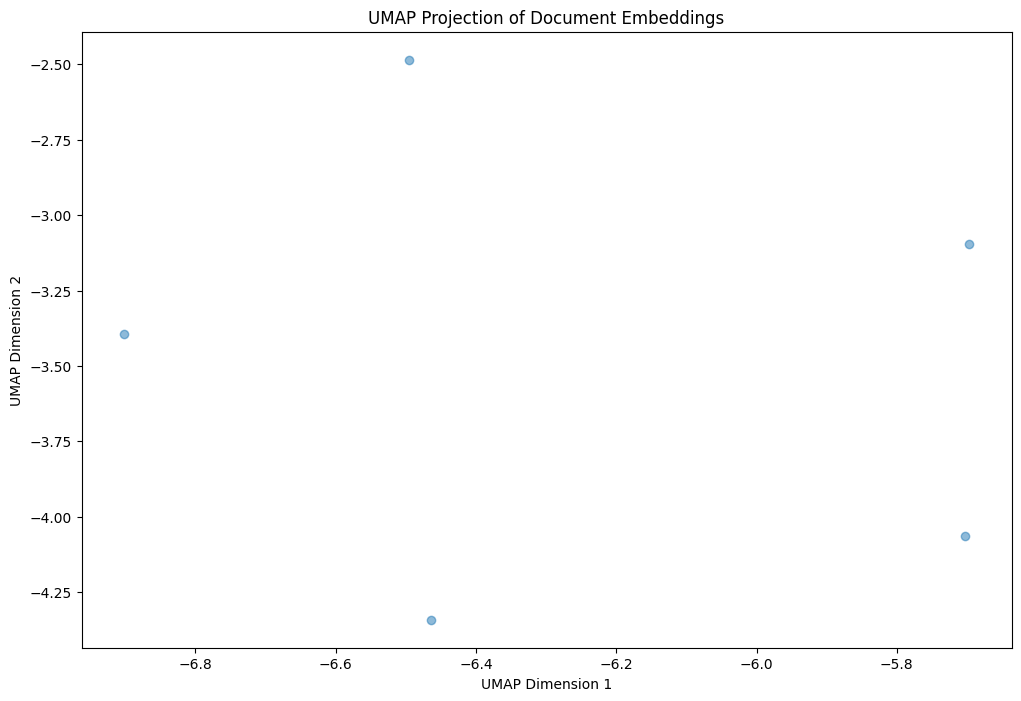

In [126]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.neighbors import NearestNeighbors
from langchain import hub
from langchain.chains import create_retrieval_chain, create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM


umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, random_state=42)

# Fit and transform the document embeddings
doc_embeddings_2d = umap_reducer.fit_transform(embeddings)

# Step 4: Visualize the document embeddings

plt.figure(figsize=(12, 8))
plt.scatter(doc_embeddings_2d[:, 0], doc_embeddings_2d[:, 1], alpha=0.5)
plt.title('UMAP Projection of Document Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


In [103]:
for content in contenido:

    print(content)

generators.
				VEERS
		Distance to power generators?
				PILOT
		One-seven, decimal two-eight.
INT. EXHAUST PIPE
Luke tumbles through the exhaust pipe.
He slides to the end of the slickly polished pipe and stops as his feet 
hit a circular grill and knock it open.  Luke claws at the surface of 
the pipe, trying to keep from sliding out into space.
EXT. BOTTOM OF CLOUD CITY - WEATHER VANE - DUSK
Unable to hang onto the pipe, Luke tumbles out, emerging at the 
undermost part of Cloud City.  Reaching out desperately, he manages to 
grab onto on electronic weather vane.
				LUKE
		Ben... Ben, please!
Luke tries to pull himself up on the weather vane but slips back down.  
He hooks one of his legs around the fragile instruments.  All the 
while, a powerful current of air rushes out at him from the exhaust 
pipe.
				LUKE
		Ben.  Leia!
erupt around them.  A gun tower is hit by a laser bolt and instantly 
explodes.  Another blast destroys a ray gun.
INT. IMPERIAL SNOW WALKER - COCKPIT
Genera

In [57]:
retriever = vector_db.as_retriever()

# Get all the documents with embeddings
docs_with_embeddings = retriever.get_relevant_documents("dummy query")

# Extract embeddings from the result
for doc in docs_with_embeddings:
    print(doc.metadata.get('embedding'))  # This will give you the embeddings if stored in metadata


C:\Users\ezequ\AppData\Local\Temp\ipykernel_9472\833370742.py:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs_with_embeddings = retriever.get_relevant_documents("dummy query")


None
None
None
None


In [54]:
# Install necessary libraries if you haven't already
# !pip install langchain umap-learn matplotlib scikit-learn

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.neighbors import NearestNeighbors
from langchain import hub
from langchain.chains import create_retrieval_chain, create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM

# 0. Initialize the LLM
llm = OllamaLLM(model='llama3.2:1b')

# 1. Load the existing ChromaDB from disk
embedding_model = OllamaEmbeddings(model="mxbai-embed-large:latest")

vector_db = Chroma(
    persist_directory=r'C:\Users\ezequ\OneDrive\Documentos\Facultad\data viz\rag\chroma_db',
    embedding_function=embedding_model  # Ensure you use the same embedding function
)

# Convert the vector store into a retriever
retriever = vector_db.as_retriever()

AttributeError: 'Chroma' object has no attribute 'add'

In [ ]:
# Install necessary libraries if you haven't already
# !pip install langchain umap-learn matplotlib scikit-learn

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.neighbors import NearestNeighbors
from langchain import hub
from langchain.chains import create_retrieval_chain, create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM

# 0. Initialize the LLM
llm = OllamaLLM(model='mistral:instruct')

# 1. Load the existing ChromaDB from disk
embedding_model = OllamaEmbeddings(model="mxbai-embed-large:latest")

vector_db = Chroma(
    persist_directory=r'C:\Users\ezequ\anyoneai\final_project\vector_db\chroma_db',
    embedding_function=embedding_model  # Ensure you use the same embedding function
)

# Convert the vector store into a retriever
retriever = vector_db.as_retriever()

# 2. Retrieve document embeddings and texts
# Note: Chroma stores embeddings internally, so we'll need to access them
# Assume that 'vector_db' has a method to retrieve embeddings and documents
# For demonstration purposes, we'll simulate this

# Simulate retrieving documents and embeddings from Chroma
# In practice, replace this with actual retrieval from your ChromaDB
documents = vector_db.get_all_documents()
doc_texts = [doc.page_content for doc in documents]
doc_embeddings = vector_db.get_all_embeddings()
doc_embeddings = np.array(doc_embeddings)

# Step 3: Apply UMAP to reduce dimensionality

# Initialize UMAP
umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, random_state=42)

# Fit and transform the document embeddings
doc_embeddings_2d = umap_reducer.fit_transform(doc_embeddings)

# Step 4: Visualize the document embeddings

plt.figure(figsize=(12, 8))
plt.scatter(doc_embeddings_2d[:, 0], doc_embeddings_2d[:, 1], alpha=0.5)
plt.title('UMAP Projection of Document Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

# Step 5: Build a NearestNeighbors model in the reduced space

# Initialize NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=5, metric='euclidean')
nn_model.fit(doc_embeddings_2d)

# Step 6: Update the retriever to use UMAP-reduced embeddings

def umap_retriever(query_embedding):
    # Project the query embedding into UMAP space
    query_embedding_2d = umap_reducer.transform([query_embedding])
    
    # Retrieve nearest neighbors
    distances, indices = nn_model.kneighbors(query_embedding_2d)
    
    # Get the retrieved documents
    retrieved_docs = [documents[idx] for idx in indices[0]]
    
    return retrieved_docs

# 7. Modify the retrieval chain to use the UMAP-based retriever

def process_query(query, chat_history):
    # Embed the query
    query_embedding = embedding_model.embed_query(query)
    
    # Retrieve relevant documents using UMAP-based retriever
    retrieved_docs = umap_retriever(query_embedding)
    
    # Visualize the query in the UMAP space
    query_embedding_2d = umap_reducer.transform([query_embedding])
    plt.figure(figsize=(12, 8))
    plt.scatter(doc_embeddings_2d[:, 0], doc_embeddings_2d[:, 1], alpha=0.5, label='Documents')
    plt.scatter(query_embedding_2d[:, 0], query_embedding_2d[:, 1], color='red', label='Query')
    plt.title('UMAP Projection with Query')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()
    plt.show()
    
    return retrieved_docs

# 8. Create the prompt and question-answering chain

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

# Update prompt to handle chat history
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# Create the question-answering chain
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

# 9. Build the final RAG chain with history-aware retriever

# Contextualize the user question based on chat history
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# Create the history-aware retriever
def history_aware_umap_retriever(llm, retriever, prompt, query, chat_history):
    # Contextualize the query
    contextualized_query = llm(prompt.format(input=query, chat_history=chat_history))
    
    # Embed the contextualized query
    query_embedding = embedding_model.embed_query(contextualized_query)
    
    # Retrieve documents using UMAP-based retriever
    retrieved_docs = umap_retriever(query_embedding)
    
    return retrieved_docs

# Final RAG chain function
def rag_chain(query, chat_history):
    # Retrieve relevant documents
    retrieved_docs = history_aware_umap_retriever(
        llm, retriever, contextualize_q_prompt, query, chat_history
    )
    
    # Prepare the context for the LLM
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])
    
    # Update chat history with retrieved context
    chat_history_placeholder = "\n".join(
        [f"{msg.role}: {msg.content}" for msg in chat_history]
    )
    
    # Generate the response
    response = question_answer_chain.invoke({
        "input": query,
        "context": context,
        "chat_history": chat_history_placeholder
    })
    
    return response



In [ ]:
# Example usage
if __name__ == "__main__":
    # Initialize an empty chat history
    chat_history = []
    
    # First question
    question = "What is Task Decomposition?"
    response1 = rag_chain(question, chat_history)
    
    # Update chat history with the interaction
    chat_history.extend([
        HumanMessage(content=question),
        AIMessage(content=response1["output_text"]),
    ])
    
    print("Answer to first question:")
    print(response1["output_text"])
    
    # Follow-up question
    second_question = "What are common ways of doing it?"
    response2 = rag_chain(second_question, chat_history)
    
    print("\nAnswer to second question:")
    print(response2["output_text"])
